# IBCS Colors Compliance Classification
 
 This notebook uses MobileNetV2 (pretrained on ImageNet) to classify dashboards as:
 - **Colors Compliant** 
 - **Colors Not Compliant**

Even though the images are stored in four folders (COLOR_COMPLIANT, COLOR_NOT_COMPLIANT, DIRECTION_COMPLIANT, DIRECTION_NOT_COMPLIANT),  
we map them to two classes (using folder names only to set the ground-truth label).  

The model itself learns to analyze the actual image content – including the color information – to decide whether an image is IBCS compliant.  


Imports

In [443]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import math
from tensorflow import keras

print("TF version:", tf.__version__)


TF version: 2.18.0


Data Loading

In [444]:
data_dir = "DataSet"
img_size = (224, 224)
batch_size = 16
val_split = 0.2
seed = 123

# This creates 4-class datasets initially, based on the 4 subfolders.
raw_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

raw_val = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

print("Original folder names:", raw_train.class_names)


Found 124 files belonging to 4 classes.
Using 100 files for training.
Found 124 files belonging to 4 classes.
Using 24 files for validation.
Original folder names: ['COLOR_COMPLIANT', 'COLOR_NOT_COMPLIANT', 'DIRECTION_COMPLIANT', 'DIRECTION_NOT_COMPLIANT']


Creating a TensorFlow Constant Mapping Table

In [445]:
mapping_table_list = []
for class_name in raw_train.class_names:
    if "COMPLIANT" in class_name:
        mapping_table_list.append(0)
    else:
        mapping_table_list.append(1)

mapping_table = tf.constant(mapping_table_list, dtype=tf.int64)
print("Mapping table:", mapping_table.numpy())


Mapping table: [0 0 0 0]


Mapping the Labels Using tf.gather

In [446]:
train_ds = raw_train.map(
    lambda x, y: (x, tf.gather(mapping_table, y)),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = raw_val.map(
    lambda x, y: (x, tf.gather(mapping_table, y)),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


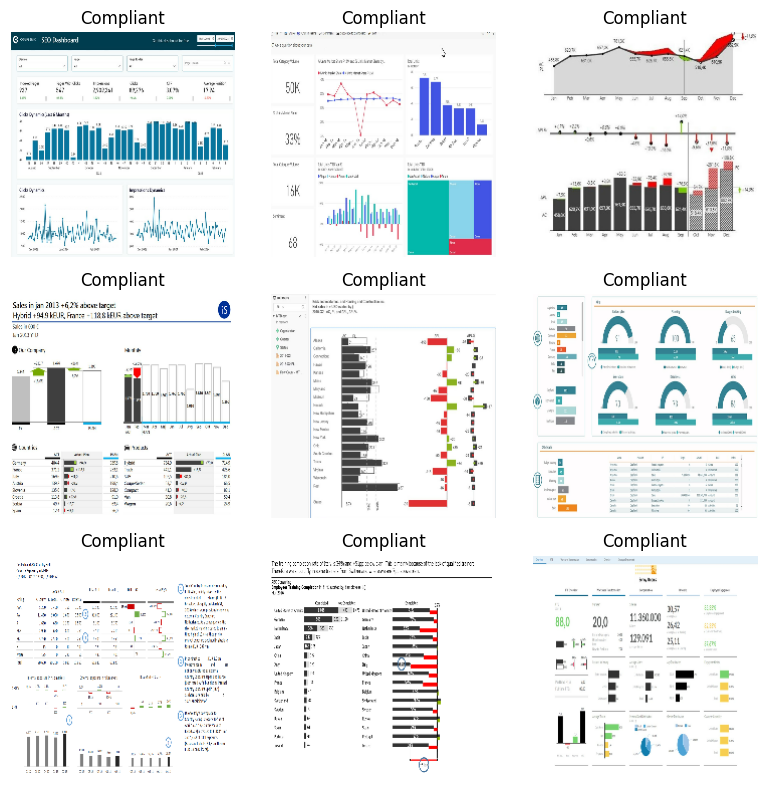

In [437]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        lbl = labels[i].numpy()
        plt.title("Compliant" if lbl == 0 else "Not Compliant")
        plt.axis("off")
plt.tight_layout()
plt.show()


Modelling


In [438]:
# MobileNetV2 is pre-trained on ImageNet, so it can extract rich image features (including colors).
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model for initial training

# Create the model input layer.
inputs = keras.Input(shape=(224, 224, 3))

# Preprocess the inputs for MobileNetV2.
x = preprocess_input(inputs)

# Pass the inputs through the pre-trained base model.
x = base_model(x, training=False)

# Global average pooling reduces the feature maps to a single vector per image.
x = layers.GlobalAveragePooling2D()(x)

# Add dropout for regularization.
x = layers.Dropout(0.2)(x)

# Final Dense layer for binary classification (2 classes: 0 - Colors Compliant, 1 - Colors Not Compliant)
outputs = layers.Dense(2, activation="softmax")(x)

# Create the complete model.
model = keras.Model(inputs, outputs)
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_21 (TrueDivide)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_21 (Subtract)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compiling & Training the Model

In [439]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Set the number of epochs for initial training.
epochs = 5

# Train the model using the preprocessed training and validation datasets.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.9429 - loss: 0.1542 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 7.1409e-04
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 7.3270e-04 - val_accuracy: 1.0000 - val_loss: 2.9126e-04
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.8637e-04 - val_accuracy: 1.0000 - val_loss: 1.8491e-04
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 2.6960e-04 - val_accuracy: 1.0000 - val_loss: 1.4538e-04


Plotting Training History

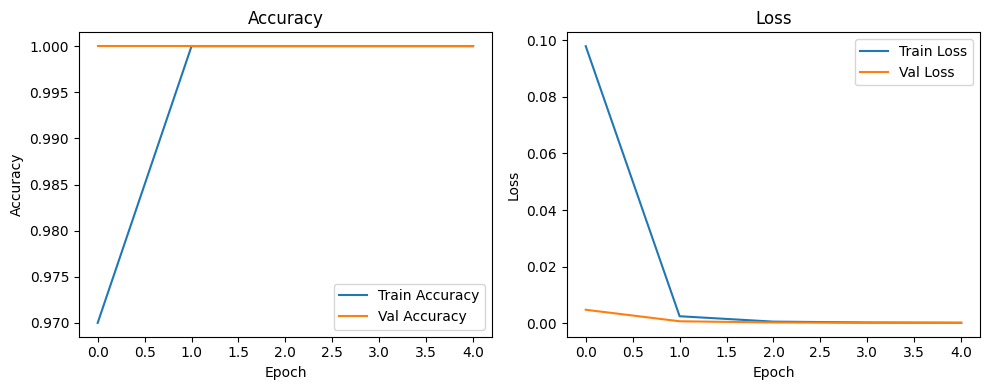

In [440]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy.
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss.
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Evaluating the Model

In [441]:
# Evaluate the model on the validation dataset.
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 1.6019e-04
Validation Accuracy: 1.00


Testing on a New Image

In [442]:
def predict_image(img_path):
    """
    Loads an image, preprocesses it, and returns the predicted class along with confidence.
    """
    # Load the image and resize it to 224x224.
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a NumPy array.
    img_array = keras.preprocessing.image.img_to_array(img)
    
    # Add a batch dimension.
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Predict the class probabilities.
    preds = model.predict(img_array)
    
    # Get the predicted class index.
    pred_idx = np.argmax(preds[0])
    
    # Map the index to the label.
    label = "Colors Compliant" if pred_idx == 0 else "Colors Not Compliant"
    
    # Return the label and confidence.
    return label, np.max(preds[0])

# Using the model to predict a new image.
test_img1 = "Testing Images\T-Image.png" 
predicted_label, confidence = predict_image(test_img)
print(f"Predicted: {predicted_label} with confidence {confidence:.2f}")
# Using the moedl for a different image.
test_img2 = "Testing Images\T-Image2.png"
predicted_label, confidence = predict_image(test_img)
print(f"Predicted: {predicted_label} with confidence {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicted: Colors Compliant with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: Colors Compliant with confidence 1.00
